In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

# 1. Dispersion relations

In [9]:
# ... dispersion relations for magnetosonic waves and shear Alfvén waves (no energetic ions)
def omegaM(k, pol):
    
    B0x   = 1.
    B0y   = 1.
    B0z   = 0.
    p0    = 1.
    rho0  = 1.
    
    gamma = 5/3                                        # ... adiabatic exponent
    cS    = np.sqrt(gamma*p0/rho0)                     # ... speed of sound
    vA    = np.sqrt((B0x**2 + B0y**2 + B0z**2)/rho0)   # ... Alfvén velocity
    
    delta = (4*B0x**2*cS**2*vA**2)/((cS**2 + vA**2)**2*(B0x**2 + B0y**2 + B0z**2))
    
    return np.sqrt(1/2*k**2*(cS**2 + vA**2)*(1 + pol*np.sqrt(1 - delta)))

def omegaS(k):
    
    B0x   = 1.
    B0y   = 1.
    B0z   = 0.
    p0    = 1.
    rho0  = 1.
    
    gamma = 5/3                                        # ... adiabatic exponent
    cS    = np.sqrt(gamma*p0/rho0)                     # ... speed of sound
    vA    = np.sqrt((B0x**2 + B0y**2 + B0z**2)/rho0)   # ... Alfvén velocity
    
    
    return vA*k*B0x/np.sqrt(B0x**2 + B0y**2 + B0z**2)
# ...




# ... dispersion relation for shear Alfvén waves + full-orbit energetic ions
def solveDispersionFullOrbit(k, pol, wch, vA, vth, v0, nuh, Ah, Zh, AMHD, initial_guess, tol, max_it=100):
    
    
    def Z(xi):
        return np.sqrt(np.pi)*np.exp(-xi**2)*(1j - sp.erfi(xi))

    def Zprime(xi):
        return -2*(1 + xi*Z(xi))
    
    
    def D(k, w, pol):
        xi = (w - k*v0 + pol*wch)/(k*vth)
        
        return 1 - vA**2*k**2/w**2 + pol*Zh*nuh*wch/(AMHD*w) + nuh*wch**2*Zh**2/(Ah*AMHD*w**2)*(w - k*v0)/(k*vth)*Z(xi)
    
    def Dprime(k, w, pol):
        xi  = (w - k*v0 + pol*wch)/(k*vth)
        xip = 1/(k*vth)
        
        return 2*vA**2*k**2/w**3 - pol*Zh*nuh*wch/(AMHD*w**2) - 2*nuh*wch**2*Zh**2/(Ah*AMHD*w**3)*(w - k*v0)/(k*vth)*Z(xi) + nuh*wch**2*Zh**2/(Ah*AMHD*w**2)*1/(k*vth)*Z(xi) + nuh*wch**2*Zh**2/(Ah*AMHD*w**2)*(w - k*v0)/(k*vth)*Zprime(xi)*xip
    
    w = initial_guess
    counter = 0
    
    while True:
        wnew = w - D(k, w, pol)/Dprime(k, w, pol)
        
        if np.abs(wnew - w) < tol or counter == max_it:
            w = wnew
            break

        w = wnew
        counter += 1

    return w, counter
# ...

In [4]:
k          = 0.75                          # wavenumber
g_sqrt     = 2*np.pi/k                   # Jacobi determinant
nuh        = 0.05                        # ration hot/cold ion number densities
rhoeq_phys = 1.                          # bulk mass density
nh0_phys   = rhoeq_phys*nuh              # hot ion number density on physical domain
nh0        = nh0_phys*g_sqrt             # hot ion number density on logical domain 
vth        = 1.                          # thermal velocity of hot ions
v0         = 2.5                         # mean velocity of hot ions

Ah         = 1.
Zh         = 1.
AMHD       = 1.

Eh_eq = nh0/2*(v0**2 + 3*vth**2/2)

w, counter = solveDispersionFullOrbit(k, +1, +1, 1., vth, v0, nuh, Ah, Zh, AMHD, 1. + 0j, 1e-10, max_it=100)

wr = np.real(w)
wi = np.imag(w)

In [5]:
wi

0.07443331592562585

# 2. Results
## 2. 1 $\delta f$
## 2. 1. 1 x - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

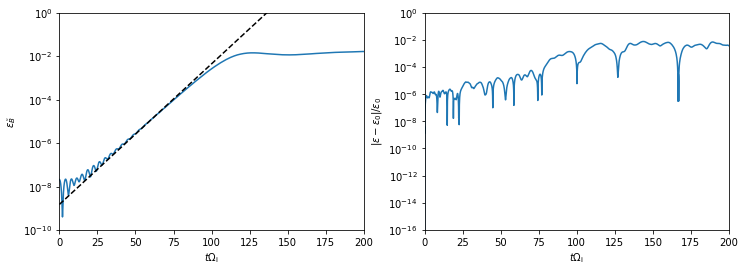

In [27]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 2 x - direction (sobol, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

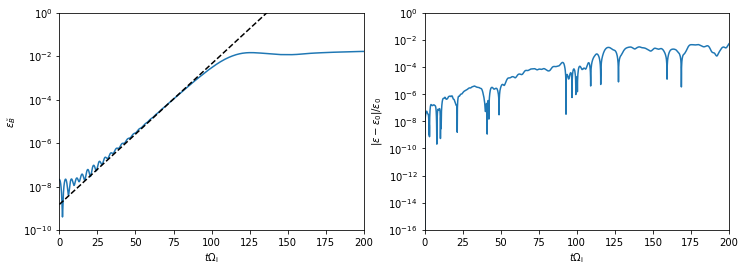

In [28]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x_sobol_ref.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 3 y - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

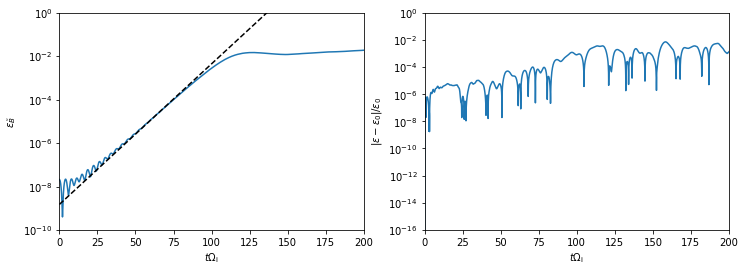

In [29]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_y.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 4 z - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

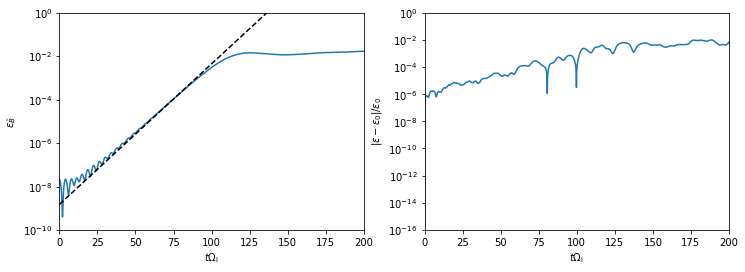

In [30]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_z.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 5 xy - direction (pseudo-random, $N_\mathrm{p}=4\cdot10^5, N_\mathrm{el}=[20, 20], \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

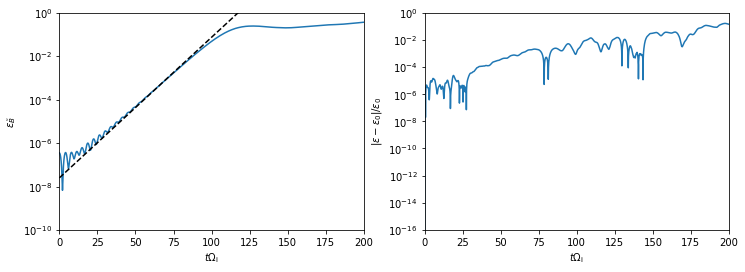

In [34]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=4e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_xy.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 2.5e-8*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2 full-$f$

## 2. 2. 1 z - direction (pseudo-random, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-5}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

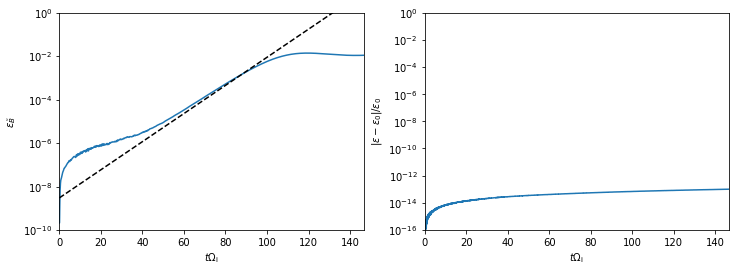

In [39]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-5_CV=off_z.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 3e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 2 z - direction (sobol, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-5}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

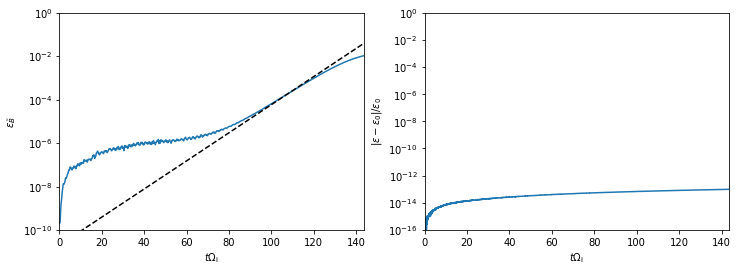

In [43]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-5_CV=off_z_sobol.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 2e-11*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 3 x - direction (pseudo-random, $N_\mathrm{p}=1\cdot10^7, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

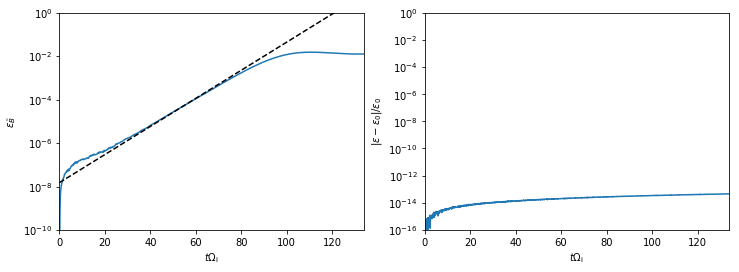

In [47]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=1e7_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_x.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-8*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 4 x - direction (sobol antithetic skip=1000, $N_\mathrm{p}=1\cdot10^7, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

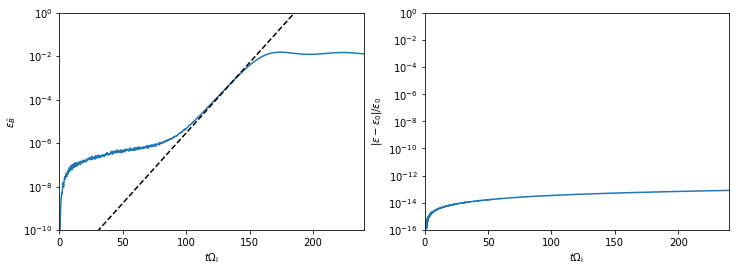

In [51]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=1e7_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_x_sobola1000.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1e-12*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 5 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=8192000, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

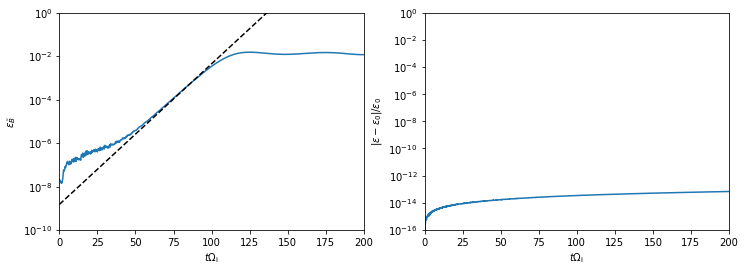

In [9]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=8192000_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=off_x_sobola.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 6 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=9932800, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

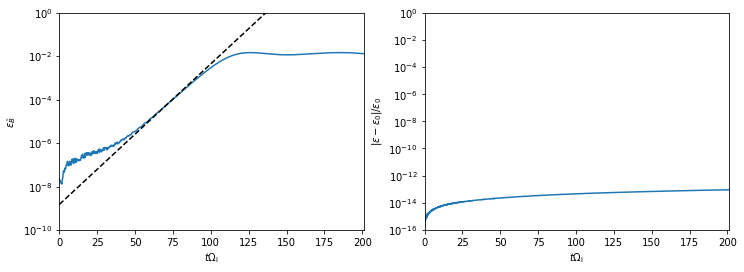

In [4]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=9932800_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 7 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=9932800, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-3}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

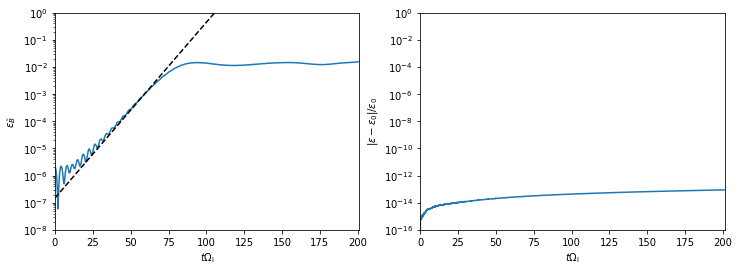

In [22]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=9932800_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-3_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-8, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 8 xy - direction (pseudo-random, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=[20,20], \Delta t=0.1, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

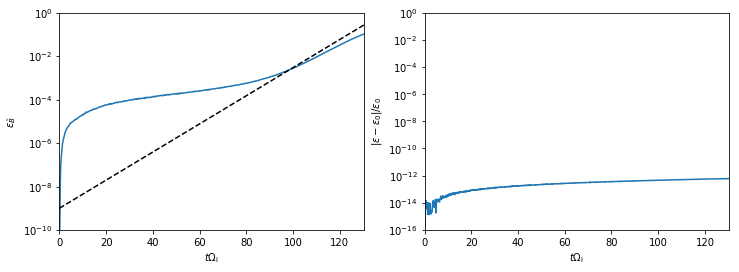

In [54]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.1_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_xy.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 3 Pure MHD

In [10]:
data = np.loadtxt('results/STRUPHY_fullMHD_angle=45.txt')

Nel  = [128, 3, 3]                # mesh generation on logical domain
bc   = [True, True, True]        # boundary conditions (True: periodic, False: else)
p    = [3, 2, 2]                 # spline degrees  
L    = [20., 1., 1.]             # box lengthes of physical domain
Ntot = Nel[0]*Nel[1]*Nel[2]
dt   = 0.05
Tend = 20.
Nt   = int(Tend/dt)

pr   = data[:, 0*Ntot:1*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
uz   = data[:, 1*Ntot:2*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
tn   = np.linspace(0., Tend, Nt + 1)


w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/Tend*w

k = np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2
k = 2*np.pi/L[0]*k

pr_fft      = np.fft.fft2(np.c_[pr[:, :, 1, 1], pr[:, 0, 1, 1]])
K, W        = np.meshgrid(k, w)
pr_fft      = np.fft.fftshift(pr_fft)
pr_fft_plot = np.abs(pr_fft)


uz_fft      = np.fft.fft2(np.c_[uz[:, :, 1, 1], uz[:, 0, 1, 1]])
K, W        = np.meshgrid(k, w)
uz_fft      = np.fft.fftshift(uz_fft)
uz_fft_plot = np.abs(uz_fft)


vFast  = omegaM(2., +1)/2.
vSlow  = omegaM(2., -1)/2.
vShear = omegaS(2.)/2.

Text(0,0.5,'w')

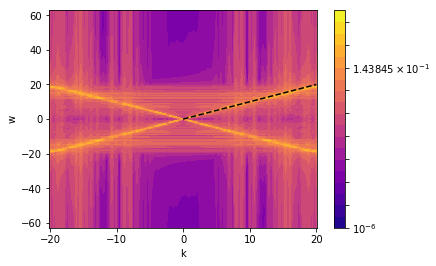

In [11]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uz_fft_plot/uz_fft_plot.max(), cmap = 'plasma', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 20, 50), 1*np.linspace(0, 20, 50), 'k--')
#plt.xlim((-10, 10))
#plt.ylim((-20, 20))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

Text(0,0.5,'w')

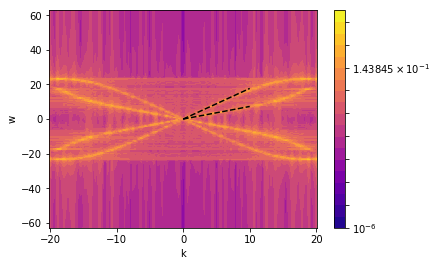

In [12]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, pr_fft_plot/pr_fft_plot.max(), cmap = 'plasma', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), 'k--')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), 'k--')
#plt.xlim((-10, 10))
#plt.ylim((-40, 40))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')